# Analyze variation in Spike with respect to protein domains and structure
This Python Jupyter notebook analyzes variation in Spike from the same proteins used the build the phylogenetic tree.
The statistics (site entropy and number of effective amino acids) is computed on the same protein set used for the tree, weight each sequence equally.
Note that this may slightly bias the results towards more recent sequences as there are more of them.

## Imports and configuration
Import modules and read configuration file:

In [1]:
import os

import Bio.SeqIO

import dna_features_viewer

from IPython.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import pdb_prot_align.main

import yaml

Read configuration:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory:

In [3]:
os.makedirs(config['variation_analysis_dir'], exist_ok=True)

## Align Spikes with PDB and domain annotations and compute site variability
We want to compute the sequence variability in the alignment in a numbering system that corresponds to that in the PDB and the domain-annotated Spike so that we can map this variability to domains and the structure.

First, get the PDB file we are using:

In [4]:
pdbfile = os.path.join(config['pdb_dir'], f"{config['pdb_id']}.pdb")
print(f"Using PDB file {pdbfile}.")
assert os.path.isfile(pdbfile)

Using PDB file results/pdbs/6u7h.pdb.


Next, read in the domain annotated Spike that we use as a "reference protein" for numbering sites when doing the analysis:

In [5]:
print(f"Reading domain-annotated Spike from {config['domain_annotated_spike']}")

domain_annotated = Bio.SeqIO.read(config['domain_annotated_spike'], 'genbank')

Reading domain-annotated Spike from data/AAK32191_hand_annotated.gp


Now write a file that includes this reference plus all the other proteins used in our tree inference:

In [6]:
prots_plus_ref = os.path.join(config['variation_analysis_dir'], 'prots_plus_ref.fasta')

print(f"Reading other Spikes from {config['spikes_unaligned_prot']}, adding reference, "
      f"and writing to {prots_plus_ref}.")

_ = Bio.SeqIO.write(
        [domain_annotated, *list(Bio.SeqIO.parse(config['spikes_unaligned_prot'], 'fasta'))],
        prots_plus_ref,
        'fasta')

Reading other Spikes from results/spikes_unaligned_prot.fasta, adding reference, and writing to results/variation_analysis/prots_plus_ref.fasta.


Use [pdb_prot_align](https://jbloomlab.github.io/pdb_prot_align/pdb_prot_align.main.html) to align the Spikes to the PDB and calculate measures of variability (entropy and number of effective amino acids).
Note that we do **not** include the PDB chains or the reference protein in the calculation of variability metrics:

In [7]:
pdb_prot_align.main.run(protsfile=prots_plus_ref,
                        refprot_regex=domain_annotated.id,
                        pdbfile=pdbfile,
                        chain_ids=config['pdb_chains'],
                        outprefix=f"{config['variation_analysis_dir']}/",
                        ignore_gaps=False,
                        drop_pdb=True,
                        drop_refprot=True,
                        )


Running `pdb_prot_align` 0.5.0

Parsing PDB results/pdbs/6u7h.pdb chains A B C
For chain A, parsed 965 residues, ranging from 37 to 1033 in PDB numbering.
For chain B, parsed 965 residues, ranging from 37 to 1033 in PDB numbering.
For chain C, parsed 965 residues, ranging from 37 to 1033 in PDB numbering.

Read 58 sequences from results/variation_analysis/prots_plus_ref.fasta
Reference protein is of length 1173 and has the following header:
AAK32191.1 spike glycoprotein [Human coronavirus 229E]

Using `mafft` to align sequences to results/variation_analysis/unstripped_alignment.fa
Stripping gaps relative to reference AAK32191.1 spike glycoprotein [Human coronavirus 229E]
Dropping PDB chains from alignment
Dropping reference protein from alignment
Writing gap-stripped alignment to results/variation_analysis/alignment.fa

Writing CSV with detailed information to results/variation_analysis/sites.csv

Program complete.



Read the data frame with the sequence variability information for each site, then re-name the columns to make it compatible with [dms-view](https://dms-view.github.io/docs/).
As shown below, there are two measures of variability: number of effective amino acids per site, and site entropy.
Also write a [dms-view](https://dms-view.github.io/docs/) metadata file:

In [8]:
orig_sitefile = os.path.join(config['variation_analysis_dir'], 'sites.csv')
print(f"Reading information on site variability from {orig_sitefile}")
site_variation = (
 pd.read_csv(orig_sitefile)
 .rename(columns={'isite': 'site',
                  'amino_acid': 'mutation',
                  'pdb_site': 'protein_site',
                  'entropy': 'site_entropy',
                  'n_effective': 'site_n_effective_amino_acids',
                  'frequency': 'mut_aa_frequency',
                  })
 .assign(label_site=lambda x: x['site'],
         condition='229E_alignment',
         protein_chain=' '.join(config['pdb_chains']),
         protein_site=lambda x: x['protein_site'].astype('Int64'),
         )
 [['site', 'label_site', 'wildtype', 'mutation', 'condition', 'protein_chain', 'protein_site',
   'site_n_effective_amino_acids', 'site_entropy', 'mut_aa_frequency']]
 .drop_duplicates()
 )

print('Here are first few lines:')
display(HTML(site_variation.head().to_html(index=False)))

print(f"\nWriting to {config['site_variation']}")
site_variation.to_csv(config['site_variation'], index=False)

print(f"\nWriting `dms-view` metadata file to {config['dms_view_metadata']}")
repo_url = f"https://github.com/jbloomlab/{os.path.basename(os.path.abspath('.'))}"
with open(config['dms_view_metadata'], 'w') as f:
    f.write('## Variability in alignment of human 229E Spike proteins\n'
            f"See [{repo_url}]({repo_url}) for details.")

Reading information on site variability from results/variation_analysis/sites.csv
Here are first few lines:


site,label_site,wildtype,mutation,condition,protein_chain,protein_site,site_n_effective_amino_acids,site_entropy,mut_aa_frequency
1,1,M,-,229E_alignment,A B C,<NA>,1.0,0.0,0.0
1,1,M,A,229E_alignment,A B C,<NA>,1.0,0.0,0.0
1,1,M,C,229E_alignment,A B C,<NA>,1.0,0.0,0.0
1,1,M,D,229E_alignment,A B C,<NA>,1.0,0.0,0.0
1,1,M,E,229E_alignment,A B C,<NA>,1.0,0.0,0.0



Writing to results/variation_analysis/site_variability.csv

Writing `dms-view` metadata file to results/variation_analysis/dms_view_metadata.md


We have chosen the reference to be the same protein used in the PDB, so the reference and PDB site numbers should always be equal.
Make sure this the case:

In [9]:
ref_and_pdb_differ = (
    site_variation
    .query('protein_site.notnull()')
    .assign(ref_and_pdb_differ=lambda x: x['site'] != x['protein_site'])
    .query('ref_and_pdb_differ')
    )
assert len(ref_and_pdb_differ) == 0, ref_and_pdb_differ

## Site variability overlaid on the domain structure
Now use [dna_features_viewer](https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/) to plot the domain structure with site variability underlaid:

<ipython-input-1-c2de04da600d>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax_var.set_xticklabels([(int(i + 1)) for i in ax_var.get_xticks()])


Saving to results/variation_analysis/domain_schematic.pdf


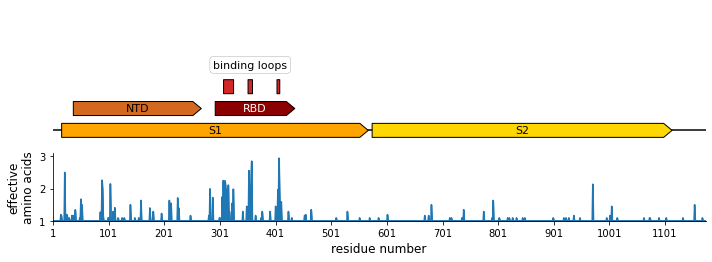

In [10]:
class SpikeTranslator(dna_features_viewer.BiopythonTranslator):
    """Custom `dna_features_viewer` translator for Spike."""
    
    def compute_filtered_features(self, features):
        return [feat for feat in features if feat.type != 'Spike']
    
    def compute_feature_color(self, feature):
        if feature.type == 'S1':
            return 'orange'
        elif feature.type == 'NTD':
            return 'chocolate'
        elif feature.type == 'RBD':
            return 'darkred'
        elif 'loop' in feature.type:
            return 'tab:red'
        else:
            return 'gold'
        
    def compute_feature_box_color(self, feature):
        return 'white'
    
    # next two methods are hacky to get a single label for binding loops
    def compute_feature_label(self, feature):
        if 'loop' in feature.type:
            if feature.type == 'binding_loop_2':
                return 'binding loops'
            else:
                return None
        else:
            return feature.type
        return feature.type.replace('_', ' ')
    
    def compute_feature_label_link_color(self, feature):
        return 'white'
    
# make all feature strands positive except loops
for feat in domain_annotated.features:
    if 'loop' in feat.type:
        feat.strand = None
    else:
        feat.strand = 1
        
# create plot
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
fig, (ax_feat, ax_var) = plt.subplots(2, 1,
                                      figsize=(10, 3.75),
                                      sharex=True,
                                      gridspec_kw={'height_ratios': [2, 1],
                                                   'wspace': 0})

# plot Spike features
graphic_record = SpikeTranslator().translate_record(domain_annotated)
_ = graphic_record.plot(with_ruler=False, ax=ax_feat)
ax_feat.margins(y=0)

# plot variability, using 0-based indexing to align and then labeling in 1-based
variability_metric = 'site_n_effective_amino_acids'
(site_variation
 .assign(site_0based=lambda x: x['site'] - 1)
 [['site_0based', variability_metric]]
 .drop_duplicates()
 .plot('site_0based', variability_metric, ax=ax_var, kind='area', legend=False, color='tab:blue')
 )
ax_var.margins(y=0)
ax_var.spines['right'].set_visible(False)
ax_var.spines['top'].set_visible(False)
ax_var.set_ylim(bottom=site_variation[variability_metric].min())
ax_var.set_xlabel('residue number', fontdict={'size': 12})
ax_var.set_ylabel('effective\namino acids', {'size': 12})
ax_var.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))
_ = ax_var.set_xticklabels([(int(i + 1)) for i in ax_var.get_xticks()])

fig.tight_layout()

print(f"Saving to {config['variation_domain_schematic']}")
plt.savefig(config['variation_domain_schematic'])